## Final Project Submission

Please fill out:
* Student name: Benjamin Bai, Nicolas Pierce, Alvaro Mendizabal
* Student pace: Full Time
* Scheduled project review date/time: 8/5/2022
* Instructor name: David Elliott
* Blog post URL: (TBD)


# Intro

### Stakeholder, Business Questions
Stakeholder: Compass, Real Estate Agency

- What are the “dealbreaker” features in a home?
- What price will homes actually sell for? 
- How should Compass allocate marketing budget and manpower?



### Data Dictionary: Column Names/Descriptions (King's County Home Data 2021-2022)
* `id` - Unique identifier for a house
* `date` - Date house was sold
* `price` - Sale price (prediction target)
* `bedrooms` - Number of bedrooms
* `bathrooms` - Number of bathrooms
* `sqft_living` - Square footage of living space in the home
* `sqft_lot` - Square footage of the lot
* `floors` - Number of floors (levels) in house
* `waterfront` - Whether the house is on a waterfront
* `greenbelt` - Whether the house is adjacent to a green belt
* `nuisance` - Whether the house has traffic noise or other recorded nuisances
* `view` - Quality of view from house
* `condition` - How good the overall condition of the house is. Related to maintenance of house.
* `grade` - Overall grade of the house. Related to the construction and design of the house.
* `heat_source` - Heat source for the house
* `sewer_system` - Sewer system for the house
* `sqft_above` - Square footage of house apart from basement
* `sqft_basement` - Square footage of the basement
* `sqft_garage` - Square footage of garage space
* `sqft_patio` - Square footage of outdoor porch or deck space
* `yr_built` - Year when house was built
* `yr_renovated` - Year when house was renovated
* `address` - The street address
* `lat` - Latitude coordinate
* `long` - Longitude coordinate

In [1]:
# Imports
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline
import statsmodels.api as sm
from statsmodels.api import OLS
import seaborn as sns
plt.style.use('seaborn-notebook')
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OrdinalEncoder, OneHotEncoder

# Remove warnings for readability
import warnings
warnings.filterwarnings("ignore")

### DataFrame

In [2]:
# Initialize dataframe from King's County House Data CSV; Parse Dates; View first 5 rows
kc_house = pd.read_csv('./data/kc_house_data.csv')
kc_house.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
# See column names
kc_house.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [4]:
# Check number rows/columns
kc_house.shape

(21597, 21)

21597 samples, 21 features

In [5]:
# See data types
kc_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

### Observations:
- 'view', 'condition', 'grade' need to be one hot encoded as categorical variables
- Need to extract 'zipcode' from address, and then 'zipcode' needs to be changed to a categorical variable

# Data Cleaning

### Initial Cleanup, Duplicate and Null Value Handling

In [6]:
# Check number of duplicate id's
kc_house['id'].duplicated().sum()

177

Need to handle 177 Duplicate IDs

In [7]:
# Drop duplicates
kc_house = kc_house.sort_values('id', ascending = False).drop_duplicates(subset = 'id', keep = 'first')

In [8]:
# Ensure that there are no longer duplicates
kc_house['id'].duplicated().sum()

0

In [9]:
# Recheck shape
kc_house.shape

(21420, 21)

In [10]:
# Drop 'id' - no longer useful as we have handled duplicate values
kc_house = kc_house.drop('id', axis=1)

In [11]:
# Check number of null values
kc_house.isnull().sum()

date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2351
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3807
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [12]:
# Check out heat_source
print(kc_house['waterfront'].value_counts())

NO     18923
YES      146
Name: waterfront, dtype: int64


In [13]:
# Waterfront is overwhelmingly 'NO' - fill missing values with 'NO'
kc_house['waterfront'].fillna('NO', inplace=True)

In [14]:
# Recheck for null values
kc_house.isna().sum()

date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront          0
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3807
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [15]:
# Check out view
print(kc_house['view'].value_counts())

NONE         19253
AVERAGE        956
GOOD           505
FAIR           329
EXCELLENT      314
Name: view, dtype: int64


In [16]:
# Vast majority of homes have 'NONE' view, fill with 'NONE'
kc_house['view'].fillna('NONE', inplace=True)

In [17]:
# Recheck for null values
kc_house.isna().sum()

date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront          0
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3807
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [18]:
# Check out yr_renovated
print(kc_house['yr_renovated'].value_counts())

0.0       16873
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1948.0        1
1976.0        1
1951.0        1
1971.0        1
1944.0        1
Name: yr_renovated, Length: 70, dtype: int64


In [19]:
# Vast majority of homes have 0, full with 0
kc_house['yr_renovated'].fillna(0, inplace=True)

In [20]:
# Final check for null values
kc_house.isna().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

### Outliers

#### Price

In [21]:
# 25 percentile, 75 percentile, iqr, whiskers 
price_q75, price_q25 = np.percentile(kc_house['price'], [75, 25])
price_iqr = price_q75 - price_q25
price_min = price_q25 - (1.5 * price_iqr)
price_max = price_q75 + (1.5 * price_iqr)

print(f"""price_min: {price_min} 
price_max: {price_max}""")

price_min: -158187.5 
price_max: 1126912.5


In [22]:
# We are setting the price range within 1.5 Standard Deviations from the 25 and 75 Percentiles
kc_house = kc_house[kc_house['price'] >= price_min]
kc_house = kc_house[kc_house['price'] <= price_max]

In [23]:
# Recheck shape to ensure we still have a large enough sample
kc_house.shape

(20269, 20)

In [24]:
kc_house['bedrooms'].value_counts()

3     9506
4     6274
2     2713
5     1321
6      218
1      190
7       30
8        9
9        4
10       2
11       1
33       1
Name: bedrooms, dtype: int64

In [25]:
# Dropping homes w/ anomalous number of bedrooms
kc_house = kc_house[kc_house['bedrooms'] != 33]
kc_house = kc_house[kc_house['bedrooms'] != 11]
kc_house = kc_house[kc_house['bedrooms'] != 10]
kc_house = kc_house[kc_house['bedrooms'] != 9]
kc_house = kc_house[kc_house['bedrooms'] != 8]

In [26]:
# Recheck shape to ensure we still have a large enough sample
kc_house.shape

(20252, 20)

### Train Test Split

In [27]:
y = kc_house['price']
X = kc_house.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.25)

### Helper Functions
- __ohe__ used for setup of categorical data
- __scale_score__ used to standardize the scale of values in test/train data and score the standardized results to get more interpretable R-squared values
- __get_train_test_metrics__ used to calculate Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RSME) for regression analysis

In [35]:
def ohe(df, df2, column):
    for col in column:
        train = df[[col]]
        ohe = OneHotEncoder(drop='first', sparse=False, handle_unknown="error")
        ohe.fit(train)
        encoded_train = ohe.transform(train)
        col_labels = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_train = pd.DataFrame(encoded_train, columns=col_labels, index=df.index)
        df = pd.concat([df, encoded_train], axis=1)
        
        test = df2[[col]]
        encoded_test = ohe.transform(test)
        col_labels = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_test = pd.DataFrame(encoded_test, columns=col_labels, index=df2.index)
        df2 = pd.concat([df2, encoded_test], axis=1)
        
    return df, df2, encoded_train.columns.tolist()

In [29]:
def scale_score(x, y, x2, y2):
    scaler = StandardScaler()
    scaler.fit(x)
    X_train_scaled = scaler.transform(x)
    X_test_scaled = scaler.transform(x2)

    lr = LinearRegression()
    lr.fit(X_train_scaled,y_train)

    train_preds = lr.predict(X_train_scaled)
    test_preds = lr.predict(X_test_scaled)
    
    print(f"""training score: {r2_score(y_train, train_preds)}
    test score: {r2_score(y_test, test_preds)}""")
    
    return X_train_scaled, X_test_scaled, train_preds, test_preds

In [30]:
def get_train_test_metrics(y_train, train_preds,
               y_test, test_preds):
    """
    Prints different training and testing metrics, namely R2, MAE, MSE, RMSE
    """
    print("\nTraining Metrics:")
    print(f"R2: {r2_score(y_train, train_preds):.3f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_train, train_preds):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_train, train_preds):.3f}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_train, train_preds, squared=False):.3f}")
    
    print("\nTesting Metrics:")
    print(f"R2: {r2_score(y_test, test_preds):.3f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, test_preds):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_test, test_preds):.3f}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_test, test_preds, squared=False):.3f}")

In [31]:
X_train.shape

(15189, 19)

### Categorical Variables

#### Condition

In [34]:
# Check out 'condition'
kc_house['condition'].value_counts()

Average      13139
Good          5379
Very Good     1547
Fair           160
Poor            27
Name: condition, dtype: int64

In [36]:
X_train, X_test, encoded_condition = ohe(X_train, X_test, ['condition'])

In [37]:
# check out encoded condition
encoded_condition

['condition_x0_Fair',
 'condition_x0_Good',
 'condition_x0_Poor',
 'condition_x0_Very Good']

In [38]:
# Map condition train
X_train['condition'] = X_train['condition'].map({'Very Good': 5, 'Good': 4, 'Average': 3, 'Fair': 2, 'Poor': 1})

In [39]:
# Map condition test
X_test['condition'] = X_test['condition'].map({'Very Good': 5, 'Good': 4, 'Average': 3, 'Fair': 2, 'Poor': 1})

#### Grade

In [42]:
kc_house['grade'].value_counts()

7 Average        8863
8 Good           5917
9 Better         2311
6 Low Average    1994
10 Very Good      764
5 Fair            234
11 Excellent      136
4 Low              27
12 Luxury           5
3 Poor              1
Name: grade, dtype: int64

In [43]:
X_train, X_test, encoded_grade = ohe(X_train, X_test, ['grade'])

In [44]:
# Check out encoded grade
encoded_grade

['grade_x0_11 Excellent',
 'grade_x0_12 Luxury',
 'grade_x0_3 Poor',
 'grade_x0_4 Low',
 'grade_x0_5 Fair',
 'grade_x0_6 Low Average',
 'grade_x0_7 Average',
 'grade_x0_8 Good',
 'grade_x0_9 Better']

Can skip mapping due to Grade starting with an integer

#### View

In [46]:
# Check out view
kc_house['view'].value_counts()

NONE         18685
AVERAGE        803
GOOD           346
FAIR           273
EXCELLENT      145
Name: view, dtype: int64

In [47]:
# OHE
X_train, X_test, encoded_view = ohe(X_train, X_test, ['view'])

In [48]:
# Map train
X_train['view'] = X_train['view'].map({'EXCELLENT': 5, 'GOOD': 4, 'AVERAGE': 3, 'FAIR': 2, 'NONE': 1})

In [49]:
# Map test
X_test['view'] = X_test['view'].map({'EXCELLENT': 5, 'GOOD': 4, 'AVERAGE': 3, 'FAIR': 2, 'NONE': 1})

#### Waterfront

In [51]:
# Check out view
kc_house['waterfront'].value_counts()

NO     20201
YES       51
Name: waterfront, dtype: int64

In [52]:
# OHE
X_train, X_test, encoded_waterfront = ohe(X_train, X_test, ['waterfront'])

In [53]:
# Map train
X_train['waterfront'] = X_train['waterfront'].map({'NO': 0, 'YES': 1})

In [54]:
# Map test
X_test['waterfront'] = X_test['waterfront'].map({'NO': 0, 'YES': 1})

#### Zipcode

In [56]:
# Check out zipcode
kc_house['zipcode'].value_counts()

98103    584
98038    583
98052    560
98115    551
98042    546
        ... 
98102     87
98109     86
98024     72
98148     56
98039      5
Name: zipcode, Length: 70, dtype: int64

In [57]:
# OHE
X_train, X_test, encoded_zipcode = ohe(X_train, X_test, ['zipcode'])

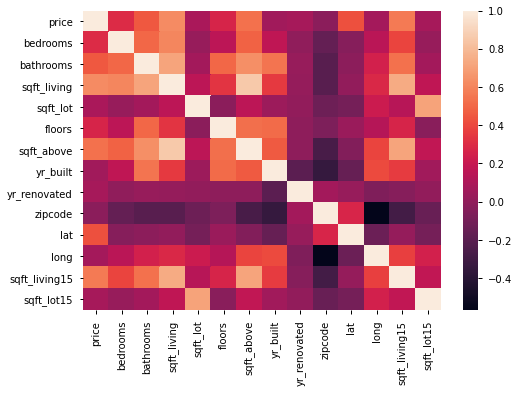

In [59]:
sns.heatmap(kc_house.corr());

In [61]:
kc_house.corr()['price'].abs().sort_values(ascending=False)

price            1.000000
sqft_living      0.621627
sqft_living15    0.562295
sqft_above       0.529990
bathrooms        0.455121
lat              0.430308
bedrooms         0.303306
floors           0.271620
sqft_lot         0.093515
sqft_lot15       0.082349
yr_renovated     0.081927
long             0.071241
yr_built         0.059637
zipcode          0.017542
Name: price, dtype: float64

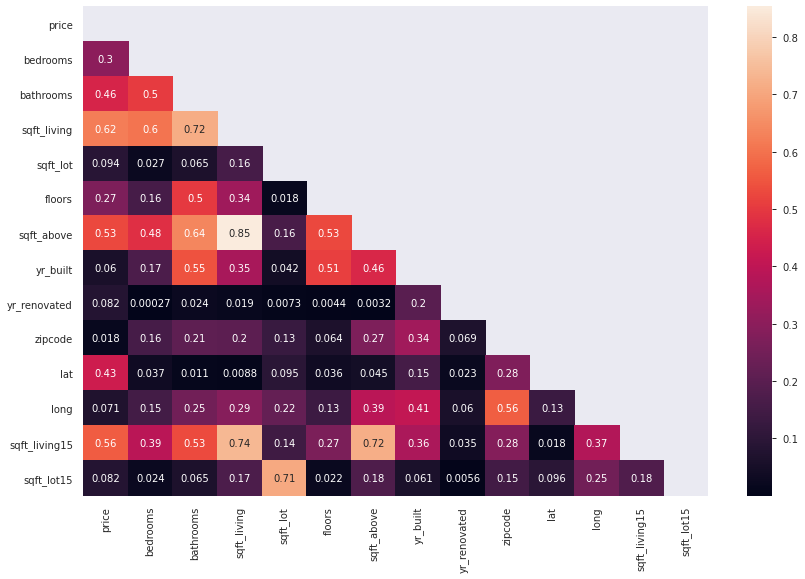

In [77]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(14, 9))
    
    mask = np.triu(np.ones_like(kc_house.corr(), dtype=bool))
    ax = sns.heatmap(abs(kc_house.corr()),mask=mask,annot=True)
    fig.savefig('images/Correlation_Heatmap_15',bbox_inches="tight");

In [100]:
corr_bar =   {'Feature': ['sqft_living','sqft_living15','sqft_above','bathrooms','lat',
                            'bedrooms','floors','sqft_lot','sqft_lot15','yr_renovated','long','yr_built','zipcode'],
               'Corr. Coefficient': [0.62,0.56,0.53,0.46,0.43,0.30,0.27,0.09,0.08,0.08,0.07,0.06,0.02]
              }
corr_bar_df = pd.DataFrame(corr_bar)

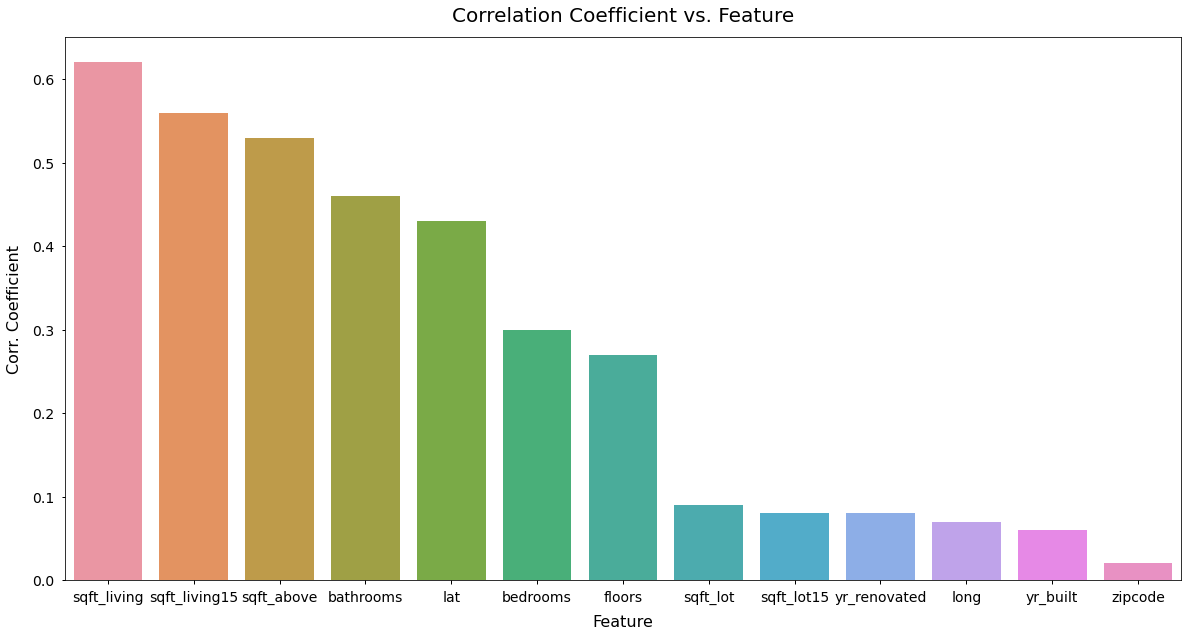

In [130]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title('Correlation Coefficient vs. Feature', fontsize=20, pad=15)
ax.set_xlabel('Feature', fontsize=16, labelpad=10)
ax.set_ylabel('Corr. Coefficient', fontsize=16, labelpad=10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.barplot(x='Feature', y='Corr. Coefficient', data=corr_bar_df)
fig.savefig('images/feature_corrcoef_bar');

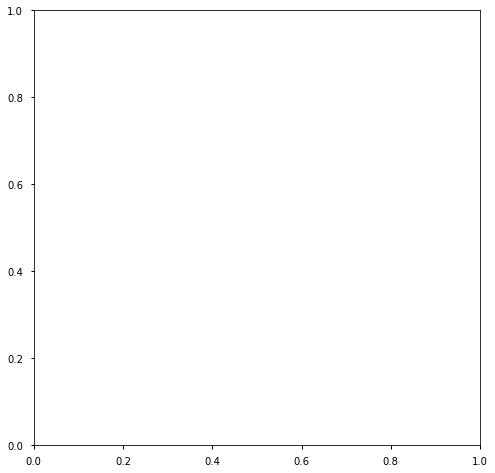

In [88]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x=)

In [65]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
basemodel_dummy_score = dummy.score(X_train, y_train)
test_dummy_score = dummy.score(X_test, y_test)

print(f"""basemodel_dummy_score: {basemodel_dummy_score}

test_dummy_score: {test_dummy_score}""")

basemodel_dummy_score: 0.0

test_dummy_score: -0.00020845214961395797


In [66]:
cols = ['sqft_living']

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [67]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.38262650697464506
    test score: 0.3974156050681469


In [68]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.383
Mean Absolute Error: 131067.886
Mean Squared Error: 26497672269.098
Root Mean Squared Error: 162781.056

Testing Metrics:
R2: 0.397
Mean Absolute Error: 130906.203
Mean Squared Error: 26330418449.385
Root Mean Squared Error: 162266.504


In [69]:
cols = encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [70]:
X_train_scaled, X_test_scaled, train_preds, test_preds=scale_score(x, y, x2, y2)

training score: 0.4781525472948359
    test score: 0.4839656173392278


In [71]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.478
Mean Absolute Error: 113103.804
Mean Squared Error: 22397694317.073
Root Mean Squared Error: 149658.593

Testing Metrics:
R2: 0.484
Mean Absolute Error: 112524.711
Mean Squared Error: 22548544808.010
Root Mean Squared Error: 150161.729


In [72]:
cols = encoded_grade

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [ ]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

In [ ]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)

In [ ]:
cols = encoded_view

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [ ]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

In [ ]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)

In [ ]:
cols = encoded_waterfront

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [ ]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

In [ ]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)

In [ ]:
cols = ['sqft_living'] + encoded_grade + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [ ]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

In [ ]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)

In [73]:
cols = ['sqft_living'] + encoded_grade + encoded_view + encoded_waterfront + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [74]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.8164835725472662
    test score: 0.8183163244031024


In [75]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.816
Mean Absolute Error: 64525.422
Mean Squared Error: 7876525645.455
Root Mean Squared Error: 88749.792

Testing Metrics:
R2: 0.818
Mean Absolute Error: 64883.567
Mean Squared Error: 7938816942.695
Root Mean Squared Error: 89100.039


# Data Exploration
Explore distributions of features, descriptive statistics, and visualizations for deeper understanding of the data

In [135]:
# Data Summary Statistics
kc_house.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.025200e+04,20252.000000,20252.000000,20252.000000,2.025200e+04,20252.000000,20252.000000,20252.000000,20252.000000,20252.000000,20252.000000,20252.000000,20252.000000,20252.000000
mean,4.774198e+05,3.325746,2.053217,1976.841645,1.462781e+04,1.477187,1710.059648,1970.923267,61.093966,98078.465287,47.556925,-122.213034,1923.985631,12452.817549
std,2.076482e+05,0.869889,0.707912,773.697852,4.016328e+04,0.537078,727.467861,29.158195,343.803383,53.325859,0.141119,0.142424,615.307853,26550.645002
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.150000e+05,3.000000,1.500000,1400.000000,5.000000e+03,1.000000,1180.000000,1952.000000,0.000000,98033.000000,47.460200,-122.330000,1470.000000,5040.000000
50%,4.380000e+05,3.000000,2.000000,1860.000000,7.500000e+03,1.000000,1520.000000,1975.000000,0.000000,98065.000000,47.567000,-122.231000,1800.000000,7540.000000
75%,6.007000e+05,4.000000,2.500000,2440.000000,1.032000e+04,2.000000,2100.000000,1996.000000,0.000000,98118.000000,47.679825,-122.122000,2280.000000,9890.000000
max,1.120000e+06,7.000000,6.750000,7480.000000,1.651359e+06,3.500000,5710.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,5380.000000,871200.000000


__Observations:__ 
- Low mean for yr_renovated suggests that the vast majority of the sample has never been renovated; dropping column as it will be difficult to get meaningful insight from it


In [ ]:
kc_house = kc_house.drop('yr_renovated', axis=1)

In [ ]:
sns.pairplot(kc_house, diag_kind = 'hist', corner = True)

__Observations:__ sqft_living, sqft_above